In [241]:
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

In [329]:
train = pd.read_csv("F:\\10 ACadamy data\\Week 4 data and report\\train.csv",low_memory=False)
store = pd.read_csv("F:\\10 ACadamy data\\Week 4 data and report\\store.csv")
test = pd.read_csv("F:\\10 ACadamy data\\Week 4 data and report\\test.csv")

In [330]:
train_data = train.merge(store, on='Store', how='left')
test_data = test.merge(store, on='Store', how='left')

## Handling Missing values

-  Creating pipeline for both numeric and categorical features

# Check for missing values

In [331]:
missing_values = train_data.isnull().sum()
logging.info(f'Missing values:\n{missing_values}')

In [332]:
train_data.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

## Map StateHoliday

In [333]:
print(train_data["SchoolHoliday"].unique()) 

[1 0]


In [334]:
print(train_data["StateHoliday"].unique()) 

['0' 'a' 'b' 'c']


In [335]:
train_data["StateHoliday"] = train_data["StateHoliday"].map({'0': 0, 'a': 1, 'b': 2, 'c': 3})
train_data["StateHoliday"].unique()

array([0, 1, 2, 3])

## Convert Date time format

In [336]:
train_data["Date"] = pd.to_datetime(train_data["Date"])

# Detect outliers

In [337]:
train_data.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                          int64
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

In [340]:
numeric = train_data.select_dtypes(include="number")
Q1 = numeric.quantile(0.25)
Q3 = numeric.quantile(0.75)
IQR = Q3 - Q1
outliers = (numeric < (Q1 - 1.5 * IQR)) | (numeric > (Q3 + 1.5 * IQR))
train_data = train_data[~outliers.any(axis=1)]
logging.info('Outliers detected and removed.')

In [341]:
train_data.StateHoliday.value_counts()

StateHoliday
0    572568
Name: count, dtype: int64

## Test Data Cleaning

In [342]:
test_data.isnull().sum()

Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                            11
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2                           0
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                17232
dtype: int64

## Replace with mean

In [343]:
# data_test["Open"] = data_test["Open"].fillna(data_test["Open"].mean())
from sklearn.impute import SimpleImputer
handle_missings = train_data.select_dtypes(include="number")

#here is for train data
for misings in handle_missings:
    imp = SimpleImputer()
    train_data[misings] = train_data[misings].fillna(train_data[misings].mean())

In [344]:
handle_missings = test_data.select_dtypes(include="number")
#for test data
for misings in handle_missings:
    imp = SimpleImputer()
    test_data[misings] = test_data[misings].fillna(test_data[misings].mean())

In [351]:
# For train_data
test_data['PromoInterval'] = test_data['PromoInterval'].fillna('No Promotions')

# For test_data
train_data['PromoInterval'] = train_data['PromoInterval'].fillna('No Promotions')

## Exploratory Analysis

- Promo Variable distribution of Test and training

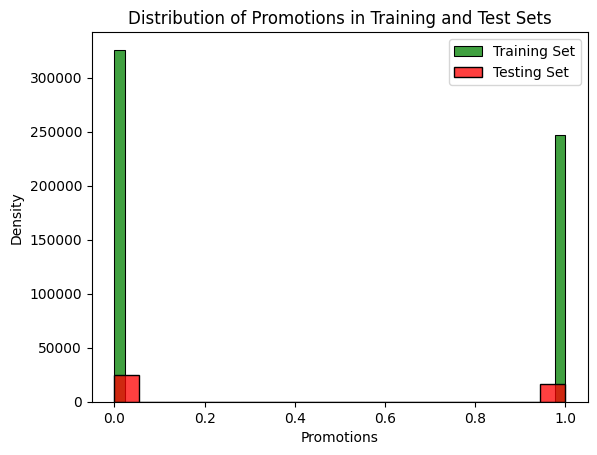

In [354]:
sns.histplot(train_data['Promo'], color="green",  label='Training Set')
sns.histplot(test_data['Promo'], color="red", label="Testing Set")

plt.title('Distribution of Promotions in Training and Test Sets')
plt.xlabel('Promotions')
plt.ylabel('Density')
plt.legend()
plt.show();

In [356]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,7.276571,2009.113456,1,45.0,2009.0,No Promotions
19,20,5,2015-07-31,9593,974,1,1,0,0,d,a,2340.0,5.000000,2009.000000,1,40.0,2014.0,No Promotions
21,22,5,2015-07-31,6566,633,1,1,0,0,a,a,1040.0,7.276571,2009.113456,1,22.0,2012.0,No Promotions
31,32,5,2015-07-31,6395,635,1,1,0,0,a,a,2910.0,7.276571,2009.113456,1,45.0,2009.0,No Promotions
35,36,5,2015-07-31,12422,1251,1,1,0,0,a,c,540.0,6.000000,2003.000000,1,40.0,2014.0,No Promotions


## Sales Behavior Around Holidays

In [357]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Create a column for holiday status
train_data['Holiday'] = train_data['StateHoliday'].apply(lambda x: 'Before' if x == '0' 
                                               else 'During' if x in ['a', 'b', 'c'] 
                                               else 'After')

# Group by holiday status and analyze sales
holiday_sales = train_data.groupby('Holiday')['Sales'].sum().reset_index()
print(holiday_sales)

  Holiday       Sales
0   After  3695304227


In [359]:
test_data.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Holiday'],
      dtype='object')

## Seasonal Purchase Behaviors

- #### # Example for Christmas (December 25)

In [364]:
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day

# Example for Christmas (December 25)
christmas_sales = train_data[(train_data['Month'] == 12) & (train_data['Day'] == 25)]
print(christmas_sales[['Sales', 'Customers']].describe())

       Sales  Customers
count    0.0        0.0
mean     NaN        NaN
std      NaN        NaN
min      NaN        NaN
25%      NaN        NaN
50%      NaN        NaN
75%      NaN        NaN
max      NaN        NaN


- ##### Example for Easter (April 9, 2023)

In [368]:
easter_sales = train_data[(train_data['Month'] == 4) & (train_data['Day'] == 9)]
print("\nEaster Sales:")
print(easter_sales[['Sales', 'Customers']].describe())


Easter Sales:
              Sales    Customers
count   1855.000000  1855.000000
mean    6266.250674   689.585984
std     2048.366780   246.547612
min     1544.000000   201.000000
25%     4715.500000   505.500000
50%     5971.000000   643.000000
75%     7534.000000   843.500000
max    13627.000000  1467.000000


- #### Example for New Year's Day (January 1)

In [366]:
new_year_sales = train_data[(train_data['Month'] == 1) & (train_data['Day'] == 1)]
print("New Year Sales:")
print(new_year_sales[['Sales', 'Customers']].describe())

New Year Sales:
       Sales  Customers
count    0.0        0.0
mean     NaN        NaN
std      NaN        NaN
min      NaN        NaN
25%      NaN        NaN
50%      NaN        NaN
75%      NaN        NaN
max      NaN        NaN


## Correlation Between Sales and Customers

In [369]:
correlation = train_data['Sales'].corr(train_data['Customers'])
print(f"Correlation between Sales and Customers: {correlation}")

Correlation between Sales and Customers: 0.7921244154156036


## Promo Effect on Sales and Customer Influx

In [370]:
promo_effect = train_data.groupby('Promo')['Sales'].mean().reset_index()
print(promo_effect)

# Check customer influx during promo
promo_customers = train_data.groupby('Promo')['Customers'].mean().reset_index()
print(promo_customers)

   Promo        Sales
0      0  5593.948509
1      1  7590.114665
   Promo   Customers
0      0  641.671179
1      1  766.726303


## Effective Promo Deployment
- To identify which stores benefit most from promotions

In [371]:
store_promo_effect = train_data.groupby(['Store', 'Promo'])['Sales'].sum().reset_index()
store_promo_effect

,Store,Promo,Sales
0,1,0,1493688
1,1,1,1455754
2,2,0,1323793
3,2,1,1740018
4,3,0,1804097
...,...,...,...
1963,1112,1,2267466
1964,1113,0,2091020
1965,1113,1,2094218
1966,1115,0,1920100


### Customer Behavior During Store Opening and Closing Times

In [373]:
train_data['Open'] = train_data['Open'].astype(bool)
opening_behavior = train_data.groupby(['Open', 'DayOfWeek'])['Sales'].mean().reset_index()
print(opening_behavior)

   Open  DayOfWeek        Sales
0  True          1  7319.910889
1  True          2  6625.812771
2  True          3  6384.534826
3  True          4  6362.629525
4  True          5  6745.107739
5  True          6  5616.340301
6  True          7  5273.294817


## Stores Open on All Weekdays

In [374]:
open_stores_weekdays = train_data[train_data['Open']].groupby('Store')['DayOfWeek'].nunique()
stores_open_all_weekdays = open_stores_weekdays[open_stores_weekdays == 5].index
weekend_sales = train_data[train_data['Store'].isin(stores_open_all_weekdays) & (train_data['DayOfWeek'].isin([5, 6]))]
print(weekend_sales[['Store', 'Sales']].groupby('Store').sum())

       Sales
Store       
335    20658


## Assortment Type Impact on Sales

In [375]:
assortment_sales = train_data.groupby('Assortment')['Sales'].mean().reset_index()
print(assortment_sales)

  Assortment        Sales
0          a  6209.975257
1          b  4607.171429
2          c  6756.045875


 ##  Distance to Competitors
 - no copition distance column in the dataset

In [380]:
train_data['CompetitionDistance'].ffill(inplace=True)

# Group by CompetitionDistance and calculate mean sales
distance_sales = train_data.groupby('CompetitionDistance')['Sales'].mean().reset_index()

# Display the result
print(distance_sales)

     CompetitionDistance         Sales
0                   20.0   5838.519293
1                   30.0   5607.373854
2                   40.0   7022.123302
3                   50.0   6132.547856
4                   60.0   8776.585538
..                   ...           ...
543              15490.0   6779.785374
544              15700.0   7258.013725
545              15710.0   8135.084359
546              15720.0   6072.037559
547              15770.0  10716.198312

[548 rows x 2 columns]


## Opening/Reopening of Competitors

In [381]:
competitor_changes = train_data[train_data['CompetitionDistance'].isna() & train_data['CompetitionDistance'].notna()]
print(competitor_changes[['Store', 'Date', 'CompetitionDistance']])

Empty DataFrame
Columns: [Store, Date, CompetitionDistance]
Index: []


In [382]:
train_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Holiday', 'Month', 'Day'],
      dtype='object')